IMPORTING LIBRARRIES AND LOADING DATA

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.signal import savgol_filter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load datasets
X_1 = pd.read_csv('original.csv')
output = pd.read_csv('reference_results.csv')
output.fillna(output.mean(), inplace=True)


DATA SMOOTHNING AND FILTERING

In [2]:
# Perform Lowess smoothing and Savitzky-Golay filtering
frac = 0.1  # Adjust the fraction as needed
smoothed_data = []

for col in X_1.columns:
    if X_1[col].dtype in ['int64', 'float64']:  # Apply only to numeric columns
        smoothed = lowess(X_1[col], X_1.index, frac=frac)
        smoothed_data.append(smoothed[:, 1])

smoothed_data = np.array(smoothed_data)

# Check the size of smoothed_data along the axis you want to filter (axis=1 for columns)
window_length = 11
if window_length <= smoothed_data.shape[1]:
    smoothed_data_savgol = savgol_filter(smoothed_data, window_length=window_length, polyorder=2, axis=1)
else:
    raise ValueError(f"window_length ({window_length}) must be <= the size of smoothed_data along axis=1 ({smoothed_data.shape[1]})")

# Convert to DataFrame
smoothed_df_savgol = pd.DataFrame(smoothed_data_savgol.T, columns=X_1.columns)

# Save smoothed and filtered data to CSV if needed
smoothed_savgol_csv = 'smoothed_data_lowess_savgol.csv'
smoothed_df_savgol.to_csv(smoothed_savgol_csv, index=False)
print(f"Smoothed and filtered data saved to '{smoothed_savgol_csv}'")


Smoothed and filtered data saved to 'smoothed_data_lowess_savgol.csv'


STANDARDIZE FEATURES AND TARGETS

In [3]:
# Standardize features
X_scaler = StandardScaler()
X_scaled = X_scaler.fit_transform(smoothed_df_savgol)

# Standardize targets
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(output)

# Combine the standardized features and target variables into one DataFrame
combined_df = pd.concat([pd.DataFrame(X_scaled), pd.DataFrame(y_scaled)], axis=1)

# Save combined data to a CSV file
combined_csv = 'combined_data.csv'
combined_df.to_csv(combined_csv, index=False)
print(f"Combined data saved to '{combined_csv}'")


Combined data saved to 'combined_data.csv'


SPLIT DATA AND TRAIN MODELS

In [4]:
# Splitting data into features and target variables
X = combined_df.iloc[:, :18]  # Assuming the first 18 columns are features
y = combined_df.iloc[:, 18:]  # The remaining columns are target variables

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Define models
models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': MultiOutputRegressor(GradientBoostingRegressor(n_estimators=100, random_state=42)),
    'LinearRegression': MultiOutputRegressor(LinearRegression()),
    'SVR': MultiOutputRegressor(SVR()),
    'KNeighbors': MultiOutputRegressor(KNeighborsRegressor())
}

# Train and evaluate models
model_performance = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred, multioutput='uniform_average')
    r2 = r2_score(y_test, y_pred, multioutput='uniform_average')
    
    model_performance[name] = {'MSE': mse, 'R2': r2}
    
    print(f"{name} model - MSE: {mse}, R2: {r2}")

# Save the best model
best_model_name = max(model_performance, key=lambda k: model_performance[k]['R2'])
best_model = models[best_model_name]
joblib.dump(best_model, 'best_model.pkl')
print(f"Best model saved as 'best_model.pkl'")


X_train shape: (76, 18)
y_train shape: (76, 13)
X_test shape: (19, 18)
y_test shape: (19, 13)
RandomForest model - MSE: 0.9138199882522163, R2: -0.061028229182204505
GradientBoosting model - MSE: 1.1886816338531174, R2: -0.5428072073206687
LinearRegression model - MSE: 1.0611940717481436, R2: -0.31357612411158614
SVR model - MSE: 0.9859925863766568, R2: -0.0898078978909566
KNeighbors model - MSE: 0.9467318842750381, R2: -0.07403501219253467
Best model saved as 'best_model.pkl'


PREDICT NEW DATA

In [5]:
def predict_soil_properties(new_data):
    """
    Predict soil properties based on new wavelength data.
    
    Args:
    - new_data: A DataFrame containing new wavelength data with the same structure as the training data.
    
    Returns:
    - predictions: A DataFrame containing the predicted soil properties.
    """
    # Load the best model
    best_model = joblib.load('best_model.pkl')
    
    # Standardize the new data
    new_data_scaled = X_scaler.transform(new_data)
    
    # Predict the soil properties
    predictions_scaled = best_model.predict(new_data_scaled)
    
    # Inverse transform the predictions to get them back to the original scale
    predictions = y_scaler.inverse_transform(predictions_scaled)
    
    # Convert predictions to DataFrame
    predictions_df = pd.DataFrame(predictions, columns=output.columns)
    
    return predictions_df

# Prediction Interface
def get_new_sample():
    """
    Gets a new sample from the user for prediction.
    """
    new_sample_data = []
    print("Enter the values for the new sample:")
    for col in smoothed_df_savgol.columns:
        value = float(input(f"{col}: "))
        new_sample_data.append(value)
    
    new_sample_df = pd.DataFrame([new_sample_data], columns=smoothed_df_savgol.columns)
    return new_sample_df


VISUALISE RESULTS

In [6]:
def visualize_results(y_test, y_pred):
    """
    Visualize the actual vs predicted soil properties.
    
    Args:
    - y_test: Actual soil properties.
    - y_pred: Predicted soil properties.
    """
    bar_width = 0.35  # Width of the bars
    for i, col in enumerate(output.columns):
        plt.figure(figsize=(10, 6))
        
        # Create positions for the bars
        indices = np.arange(len(y_test))
        
        # Plot the bars
        plt.bar(indices - bar_width/2, y_test[:, i], bar_width, alpha=0.6, label='Actual')
        plt.bar(indices + bar_width/2, y_pred[:, i], bar_width, alpha=0.6, label='Predicted')
        
        plt.xlabel('Sample Index')
        plt.ylabel('Value')
        plt.title(f'Actual vs Predicted - {col}')
        plt.legend()
        plt.tight_layout()
        plt.show()


MAIN FUNCTION

Predict Soil Properties from Wavelength Data
Enter the values for the new sample:

Predicted Soil Properties:
       pH  EC  (dS/m)  OC (%)  P   (kg/ha)  K (kg/ha)  Ca (meq/100g)  \
0  7.6539      0.7118  0.8106       15.698   597.9456      40.269837   

   Mg (meq/100g)  S (ppm)  Fe (ppm)  Mn (ppm)  Cu (ppm)  Zn (ppm)  B (ppm)  
0        17.1375   16.152   12.2779    6.0795     3.616    0.9412    0.403  


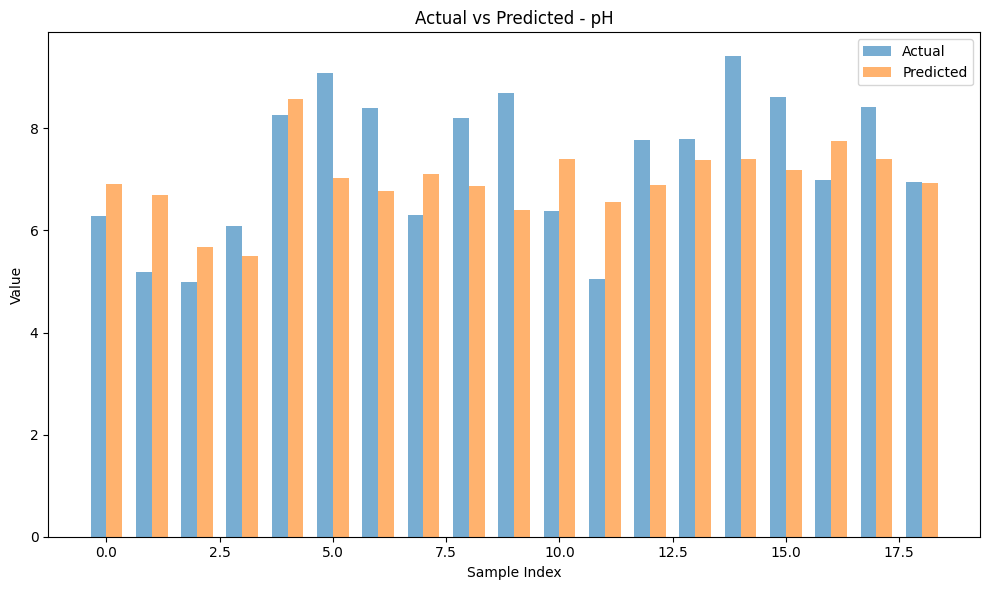

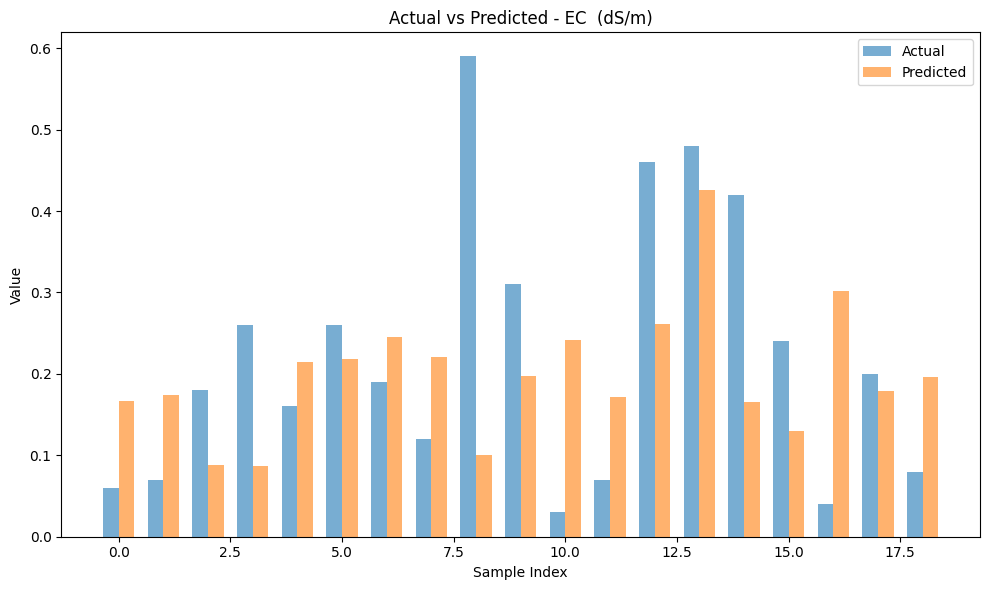

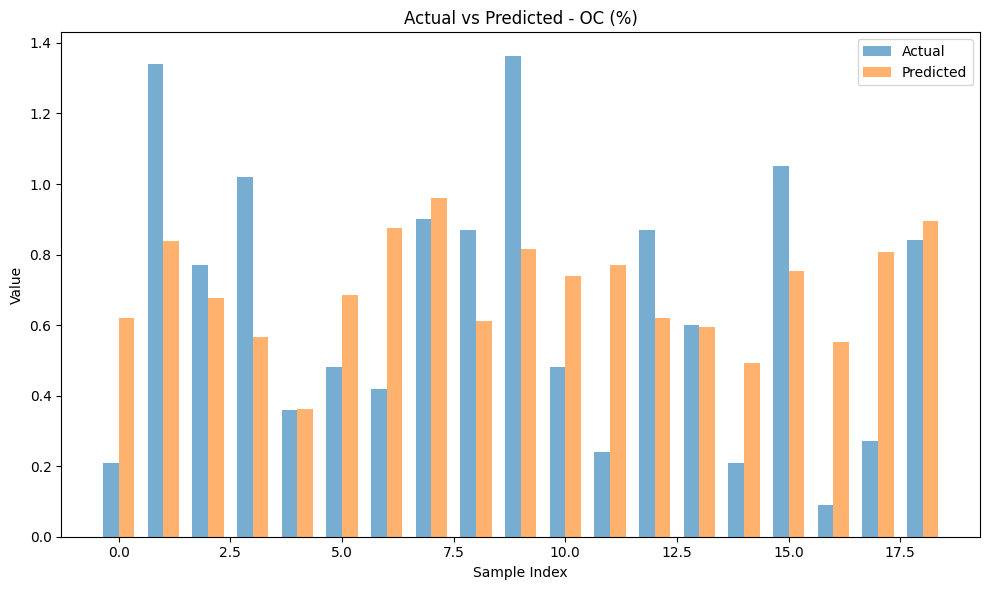

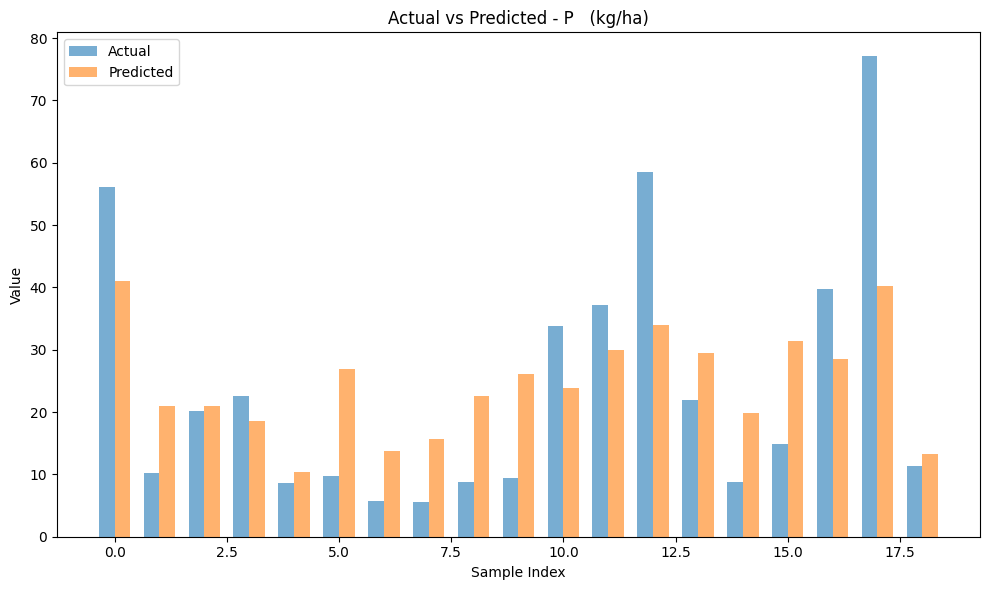

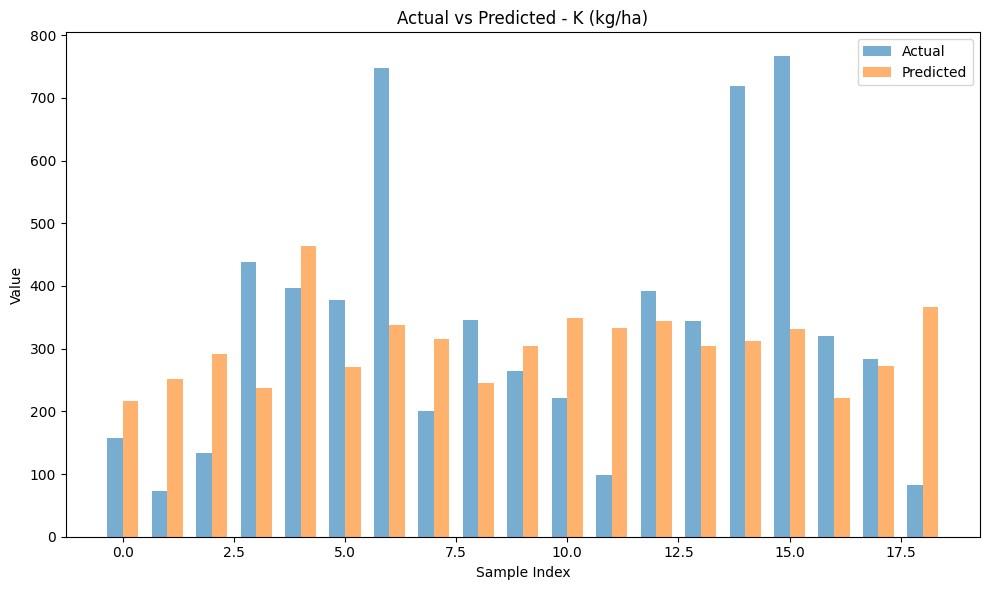

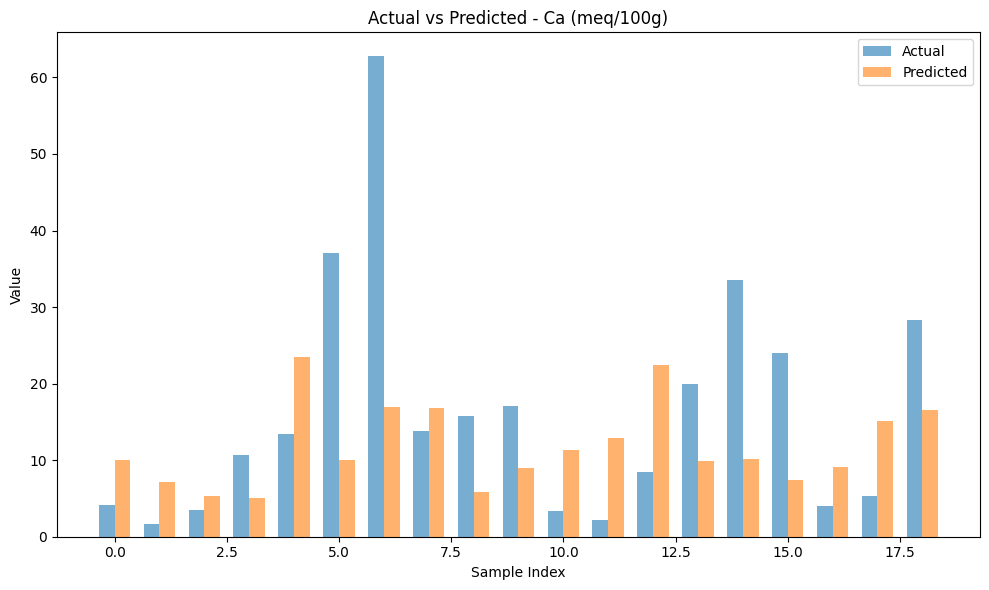

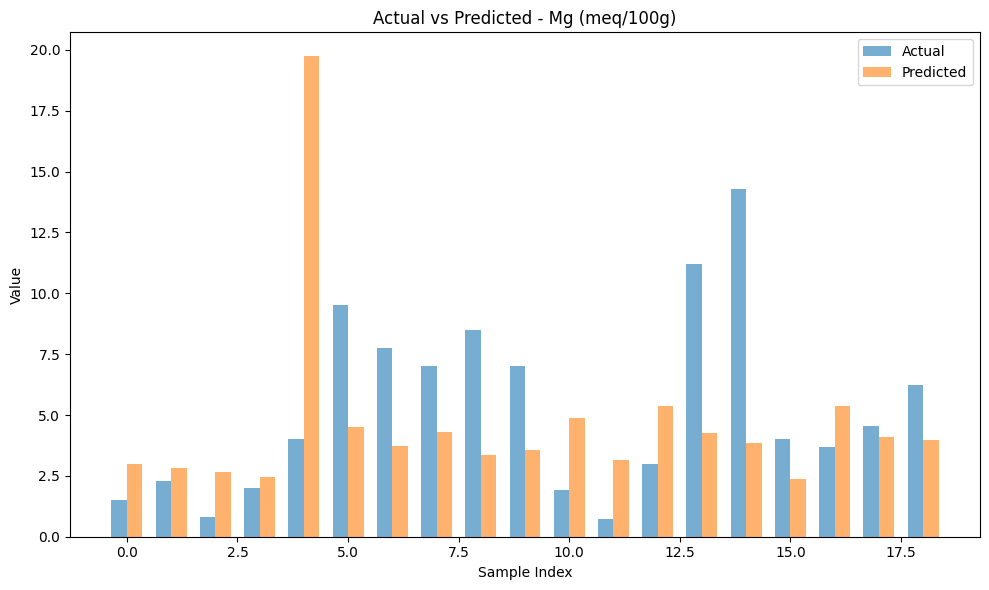

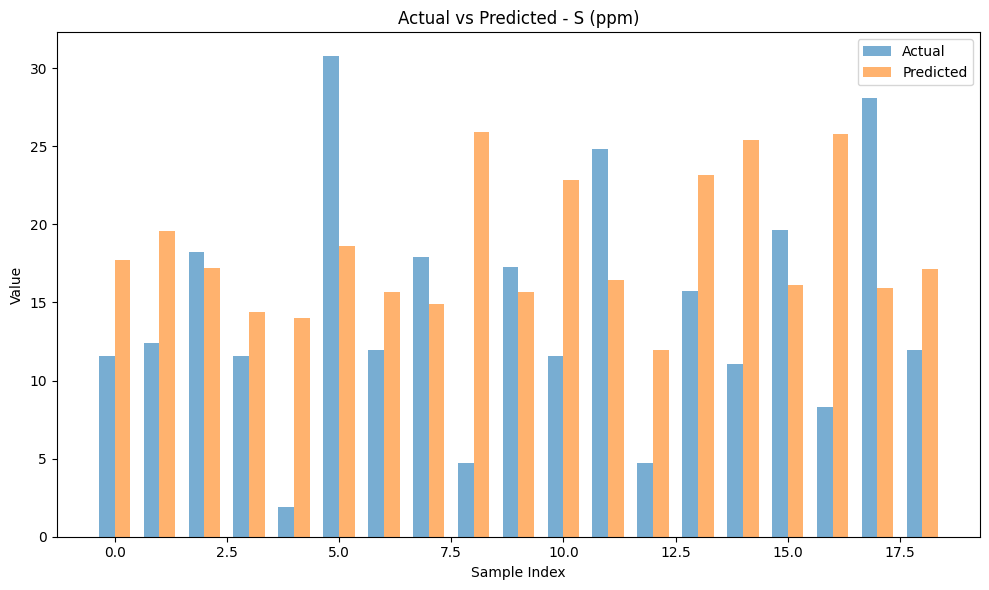

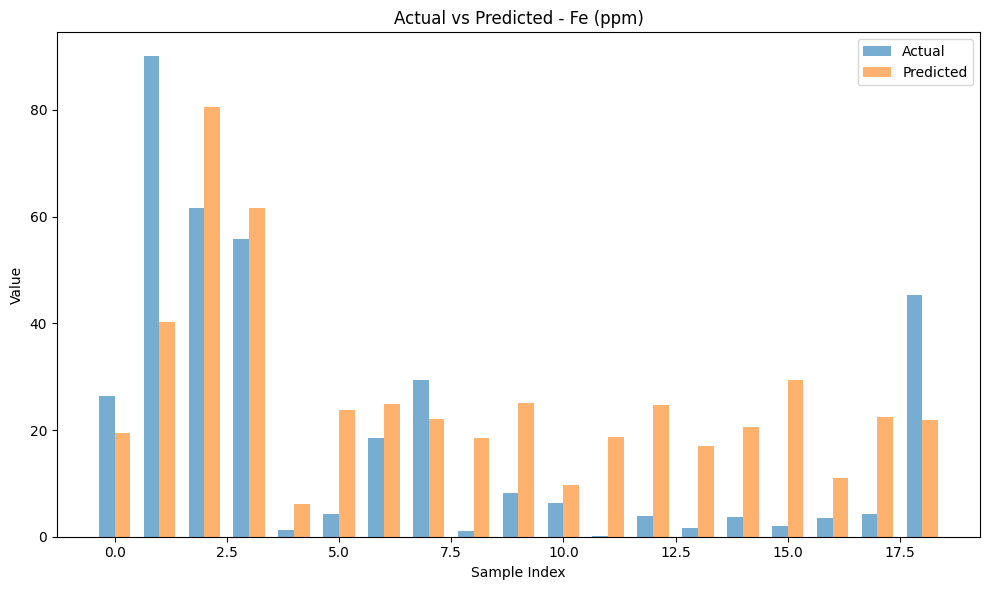

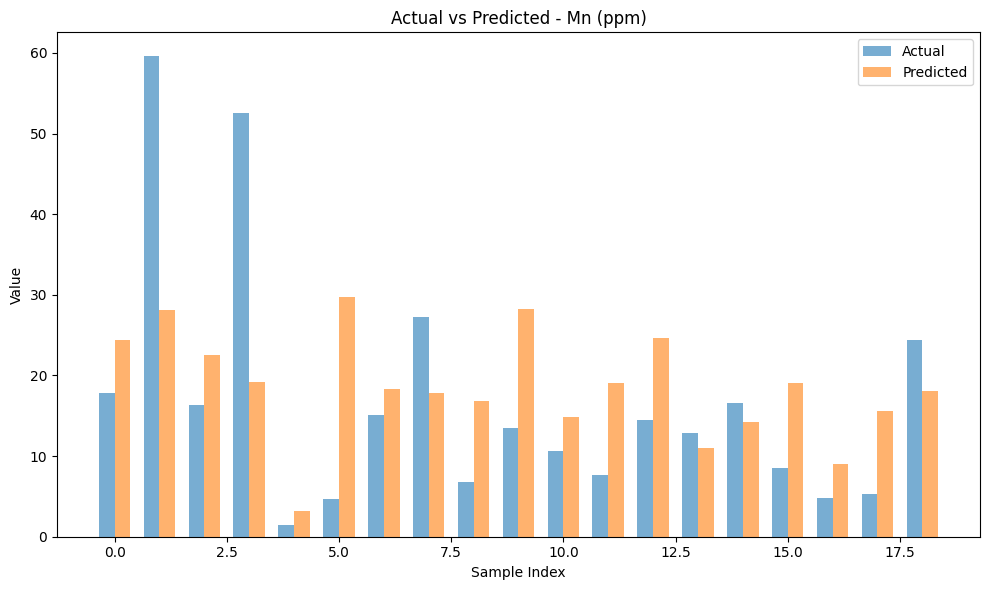

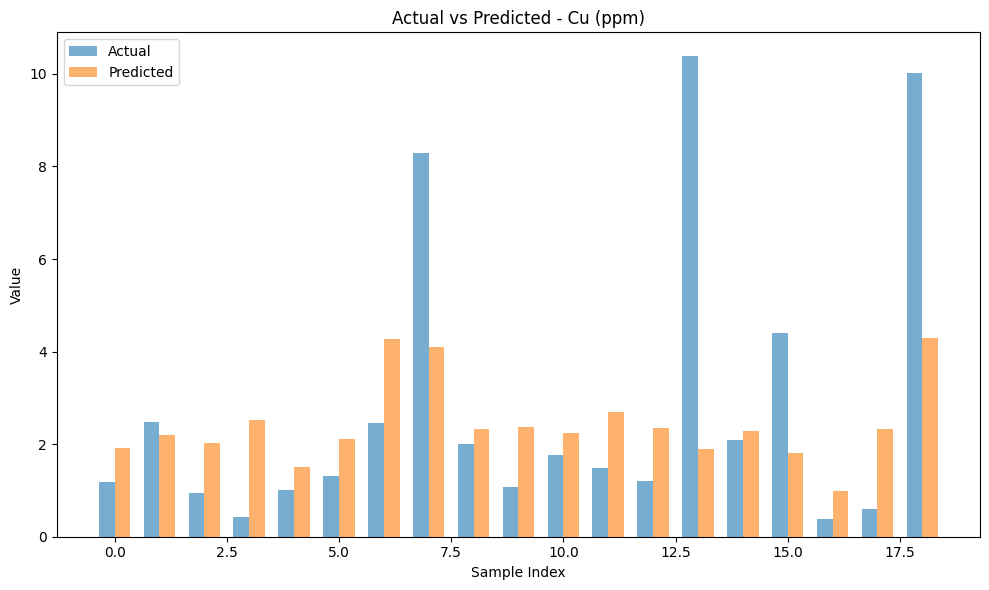

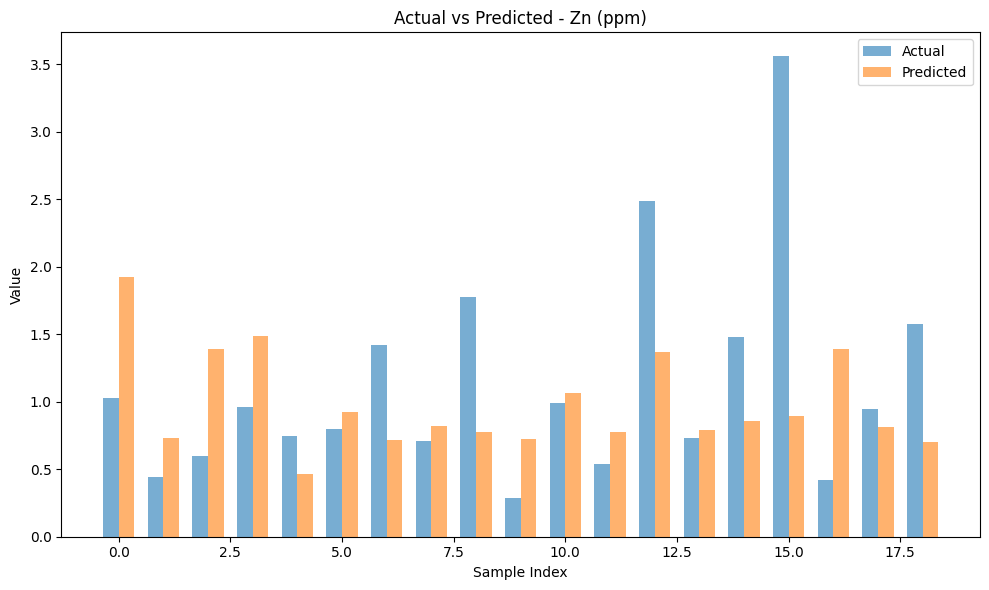

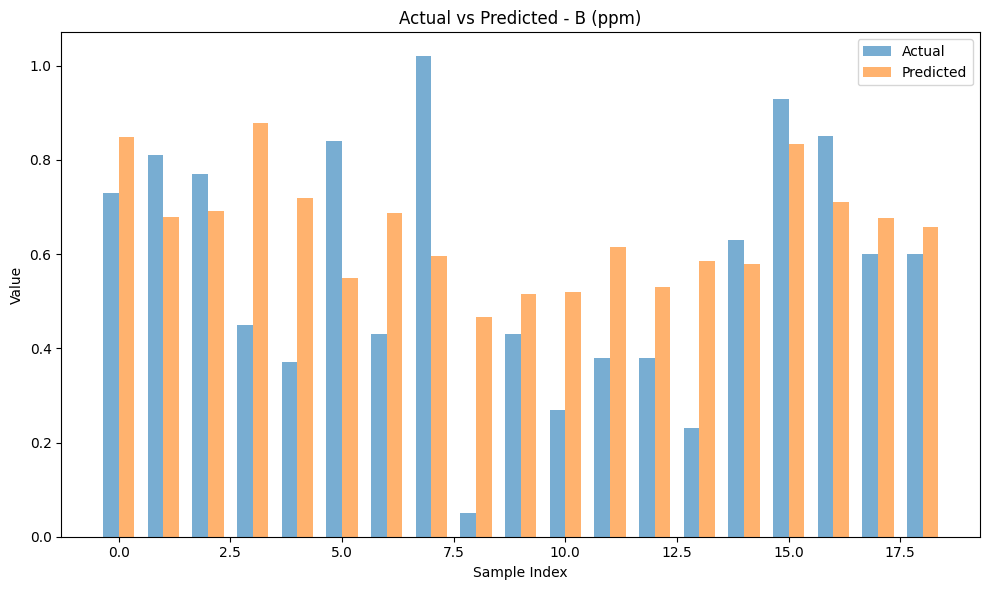

In [13]:
def main():
    """
    Main function to run the prediction interface.3
    """
    print("Predict Soil Properties from Wavelength Data")
    new_sample_df = get_new_sample()
    predicted_properties = predict_soil_properties(new_sample_df)
    print("\nPredicted Soil Properties:")
    print(predicted_properties)
    
    # Visualize the model performance on the test set
    best_model = joblib.load('best_model.pkl')
    y_pred_test = best_model.predict(X_test)
    y_test_scaled = y_scaler.inverse_transform(y_test)
    y_pred_test_scaled = y_scaler.inverse_transform(y_pred_test)
    visualize_results(y_test_scaled, y_pred_test_scaled)

if __name__ == "__main__":
    main()
